In [1]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import math
import seaborn as sb
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import transforms as T
from torch import optim
from tqdm import tqdm
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
meteoData = pd.read_csv("podaci_final_VV_popunjeno_bezH.csv")
pollutionData = pd.read_csv("pollutionData.csv")

In [3]:
del pollutionData['Unnamed: 0']
del pollutionData['MernaStanica']

In [4]:
pollutionData.columns

Index(['Datum_i_Vreme', 'CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2'], dtype='object')

In [5]:
meteoData.columns

Index(['DateTime', 'T', 'P', 'U', 'Ff', 'Nh', 'VV', 'sss', 'DD_Calm, no wind',
       'DD_Wind blowing from the east',
       'DD_Wind blowing from the east-northeast',
       'DD_Wind blowing from the east-southeast',
       'DD_Wind blowing from the north', 'DD_Wind blowing from the north-east',
       'DD_Wind blowing from the north-northeast',
       'DD_Wind blowing from the north-northwest',
       'DD_Wind blowing from the north-west', 'DD_Wind blowing from the south',
       'DD_Wind blowing from the south-east',
       'DD_Wind blowing from the south-southeast',
       'DD_Wind blowing from the south-southwest',
       'DD_Wind blowing from the south-west', 'DD_Wind blowing from the west',
       'DD_Wind blowing from the west-northwest',
       'DD_Wind blowing from the west-southwest',
       'DD_variable wind direction'],
      dtype='object')

In [6]:
pollutionData.columns = ['DateTime', 'CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']

In [7]:
pollutionData = pollutionData.merge(meteoData, how = 'inner', on = "DateTime")

In [8]:
del pollutionData['DateTime']

In [9]:
yData = pollutionData[['CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']]

In [10]:
xData = pollutionData.drop(['CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2'], axis = 1)

In [11]:
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
                    
        self.fnn = nn.Sequential(
            nn.Linear(25, 64),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            
            nn.Linear(64, 6),
            nn.ReLU()
        )
        
    def forward(self, input):
        return self.fnn(input)

In [12]:
def testLoop(fnn, testLoader):
    mseLoss = 0
    maeLoss = 0
    
    optimizer = optim.Adam(fnn.parameters())
    criterion = torch.nn.MSELoss()
    criterionMAE = torch.nn.L1Loss()
    
    with torch.no_grad():
        for data, target in testLoader:
            data, target = data.to(device), target.to(device)
            output = fnn(data)
            
            loss = criterion(output, target)
            mseLoss += loss.item()
            
            loss = criterionMAE(output, target)
            maeLoss += loss.item()

    mseLoss /= len(testLoader)
    maeLoss /= len(testLoader)

    return mseLoss, maeLoss

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = FullyConnected()

model.load_state_dict(torch.load('modelPollution_12.58'))
model.to(device)
model.eval()

FullyConnected(
  (fnn): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=6, bias=True)
    (10): ReLU()
  )
)

In [15]:
yData = [[y] for y in yData.values]
yData = torch.Tensor(yData)

In [16]:
xData = [[y] for y in xData.values]
xData = torch.Tensor(xData)

In [17]:
_, X_test, _, y_test = train_test_split(xData, yData, random_state = 12, test_size = 0.2)

In [18]:
testDataset = data_utils.TensorDataset(X_test, y_test)

In [19]:
batchSize = 64

In [20]:
testLoader = DataLoader(testDataset, shuffle=True, num_workers=0, batch_size=batchSize)

In [21]:
testLoss = testLoop(model, testLoader)

In [22]:
print('MSE: ' + str(testLoss[0]) + ', MAE: ' + str(testLoss[1]))

MSE: 1086.5275693903316, MAE: 12.566996475575502


In [23]:
O3_bounds = np.array([ 54, 125, 165, 205, 405, 504, 604], dtype=np.float64) * 2.00
PM25_bounds = np.array([12, 35.4, 55.4, 150.4, 250.4, 350.4, 500.4], dtype=np.float64)
PM10_bounds = np.array([54, 154, 254, 354, 424, 504, 604], dtype=np.float64)
CO_bounds = np.array([4.4, 9.4, 12.4, 15.4, 30.4, 40.4, 50.4], dtype=np.float64) * 1.145
SO2_bounds = np.array([35, 75, 185, 304, 604, 804, 1004], dtype=np.float64) * 2.62
NO2_bounds = np.array([53, 100, 360, 649, 1249, 1649, 2049], dtype=np.float64) * 1.88

I_bounds = np.array([50, 100, 150, 200, 300, 400, 500], dtype=np.float64)

In [24]:
def calcI(Clow, Chigh, Ilow, Ihigh, C):
    return 1.0 * ((Ihigh - Ilow) / (Chigh - Clow)) * (C - Clow) + Ilow

In [35]:
def calcLowHigh(dataName, C):
    if dataName == "O3":
        index = np.searchsorted(O3_bounds, C)
        Chigh = O3_bounds[min(index+1, 6)]
        Clow = O3_bounds[index]
        Ihigh = I_bounds[min(index+1, 6)]
        Ilow = I_bounds[index]
                             
        return Clow, Chigh, Ilow, Ihigh
    
    if dataName == "PM25":
        index = np.searchsorted(PM25_bounds, C)
        Chigh = PM25_bounds[min(index+1, 6)]
        Clow = PM25_bounds[index]
        Ihigh = I_bounds[min(index+1, 6)]
        Ilow = I_bounds[index]
        return Clow, Chigh, Ilow, Ihigh  
    
    if dataName == "PM10":
        index = np.searchsorted(PM10_bounds, C)
        Chigh = PM10_bounds[min(index+1, 6)]
        Clow = PM10_bounds[index]
        Ihigh = I_bounds[min(index+1, 6)]
        Ilow = I_bounds[index]
        return Clow, Chigh, Ilow, Ihigh  
    
    if dataName == "CO":
        index = np.searchsorted(CO_bounds, C)
        Chigh = CO_bounds[min(index+1, 6)]
        Clow = CO_bounds[index]
        Ihigh = I_bounds[min(index+1, 6)]
        Ilow = I_bounds[index]
        return Clow, Chigh, Ilow, Ihigh  
    
    if dataName == "SO2":
        index = np.searchsorted(SO2_bounds, C)
        Chigh = SO2_bounds[min(index+1, 6)]
        Clow = SO2_bounds[index]
        Ihigh = I_bounds[min(index+1, 6)]
        Ilow = I_bounds[index]
        return Clow, Chigh, Ilow, Ihigh
    
    if dataName == "NO2":
        index = np.searchsorted(NO2_bounds, C)
        Chigh = NO2_bounds[min(index+1, 6)]
        Clow = NO2_bounds[index]
        Ihigh = I_bounds[min(index+1, 6)]
        Ilow = I_bounds[index]
        return Clow, Chigh, Ilow, Ihigh  

In [36]:
def getCategory(api):
    categories = ['good', 'moderate', 'unhealthy for some', 'unhealthy', 'very unhealthy', 'hazardous']
    index = np.searchsorted(I_bounds, api)
    return categories[index], index
        

In [92]:
meteoData = pd.read_csv("podaci_final_VV_popunjeno_bezH.csv")

In [93]:
dots = 361
meteoData = meteoData[-1:-24*dots:-24]
meteoData

,DateTime,T,P,U,Ff,Nh,VV,sss,"DD_Calm, no wind",DD_Wind blowing from the east,...,DD_Wind blowing from the north-west,DD_Wind blowing from the south,DD_Wind blowing from the south-east,DD_Wind blowing from the south-southeast,DD_Wind blowing from the south-southwest,DD_Wind blowing from the south-west,DD_Wind blowing from the west,DD_Wind blowing from the west-northwest,DD_Wind blowing from the west-southwest,DD_variable wind direction
78465,2021-03-31 23:00,11.9,1022.5,67,1.000000,0,10.000000,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
78441,2021-03-30 23:00,10.1,1029.0,73,1.000000,0,10.000000,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
78417,2021-03-29 23:30,10.0,1031.8,0,11.938297,0,18.305286,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
78393,2021-03-29 11:30,14.0,1033.9,2,12.755862,0,18.621237,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
78369,2021-03-28 23:30,9.0,1032.9,0,12.225293,0,18.281395,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69921,2020-05-12 23:00,11.7,1019.9,54,2.000000,50,20.000000,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
69897,2020-05-11 23:00,23.1,1004.2,26,5.000000,50,20.000000,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
69873,2020-05-10 23:00,20.7,1010.1,58,2.000000,0,10.000000,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
69849,2020-05-09 23:00,19.3,1012.9,47,2.000000,0,10.000000,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [94]:
del meteoData["DateTime"]

In [95]:
elements = ['CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']

In [96]:
xData = [[y] for y in meteoData.values]
xData = torch.Tensor(xData).to(device)

In [97]:
with torch.no_grad():
    output = model(xData).cpu()

In [98]:
points = []
for out in output:
    maxI = 0
    out = torch.squeeze(out, axis=0).numpy()
    for name, val in zip(elements, out):
        Clow, Chigh, Ilow, Ihigh = calcLowHigh(name, val)
        I = calcI(Clow, Chigh, Ilow, Ihigh, val)
        if ( I > maxI ):
            maxI = I
    points.append(maxI)

In [99]:
xTicks = [i for i in range(dots)]

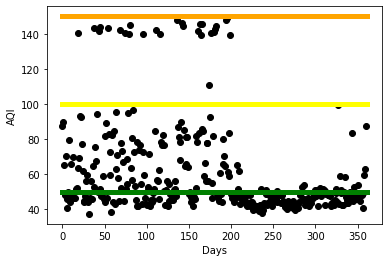

In [115]:
plt.scatter(xTicks, points, c='black', linewidth=1)
plt.xlabel('Days')
plt.ylabel('AQI')

plt.plot([0, 361], [50, 50], c="green", linewidth=5)
plt.plot([0, 361], [100, 100], c="yellow", linewidth=5)
plt.plot([0, 361], [150, 150], c="orange", linewidth=5)
# plt.plot([0, 361], [200, 200], c="red", linewidth=5)
# plt.plot([0, 361], [300, 300], c="purple", linewidth=5)
# plt.plot([0, 361], [400, 400], c="purple", linewidth=5)
# plt.plot([0, 361], [500, 500], c="purple", linewidth=5)                  